In [1]:
import numpy as np 
import os
import pandas as pd
from PIL import Image
import slideio
import matplotlib.pyplot as plt
import cv2
import math
import tensorflow as tf

2024-01-26 10:50:55.765812: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 10:50:56.368210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
Transfer_df=pd.read_csv('../../data/100x_Transfer.csv')
HE_svs_path='../../data/svs/HE/'
stain_svs_path='../../data/svs/'
def rotate_and_translate_coordinates(coords, angle_degrees, translation_x, translation_y, image_width, image_height):
    # 각도를 라디안으로 변환
    angle_rad = np.radians(angle_degrees)
    
    # 이미지 중심으로 이동
    coords_centered = coords - np.array([image_width / 2, image_height / 2])
    
    # 회전 행렬 구성
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                               [np.sin(angle_rad), np.cos(angle_rad)]])
    
    # 좌표 회전
    rotated_coordinates = np.dot(coords_centered, rotation_matrix.T)
    
    # 이동
    rotated_and_translated_coordinates = rotated_coordinates + np.array([translation_x, translation_y])
    
    # 다시 이미지 중심으로 이동
    rotated_and_translated_coordinates += np.array([image_width / 2, image_height / 2])
    
    return rotated_and_translated_coordinates
def rotate(xy, angle):
    x, y = xy
    x = x - 512
    y = y - 512
    rad = np.deg2rad(angle)
    x1 = x * np.cos(rad) - y * np.sin(rad)
    y1 = x * np.sin(rad) + y * np.cos(rad)
    x1 = x1 + 512
    y1 = y1 + 512
    x1=x1-x1.min()
    y1=y1-y1.min()
    x1=x1/x1.max()*1023
    y1=y1/y1.max()*1023
    x1=x1.astype(int)
    y1=y1.astype(int)
    return x1, y1

JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [2,1].
JPEGFixupTagsSubsamplingSec: Warning, Auto-corrected former TIFF subsampling value

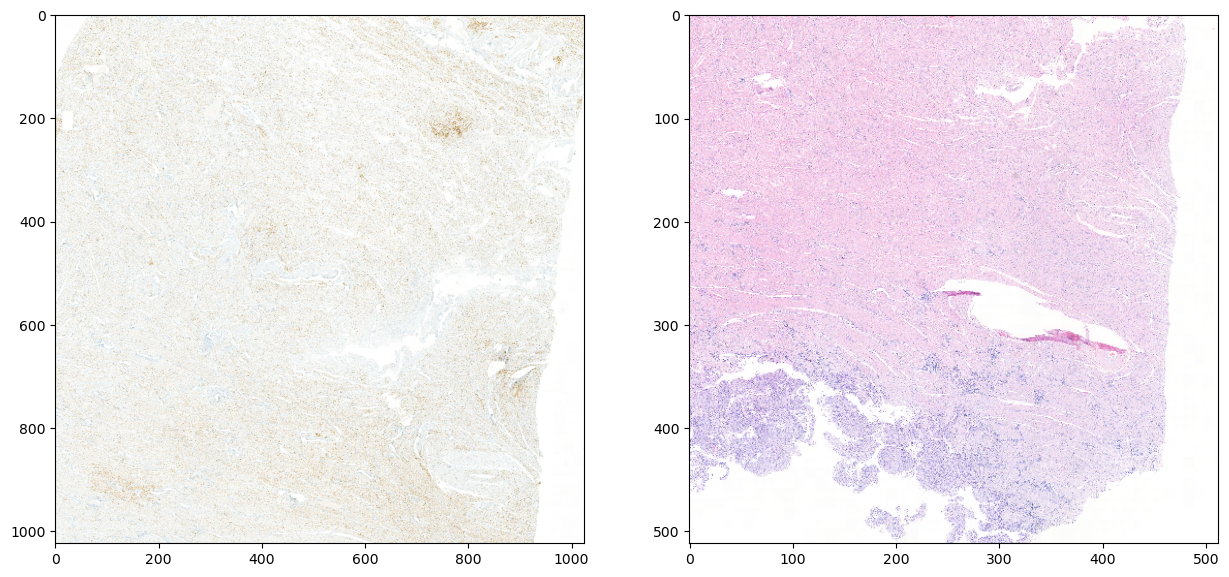

In [27]:
image_size=512
i=8
fileName=Transfer_df.loc[i]['slide']
stain=Transfer_df.loc[i]['stain']
x=Transfer_df.loc[i]['x']*100
y=Transfer_df.loc[i]['y']*200
angle=Transfer_df.loc[i]['angle']
he_slide = slideio.open_slide(HE_svs_path+fileName+'.svs', "SVS")
stain_slide = slideio.open_slide(stain_svs_path+stain+'/'+fileName+'.svs', "SVS")
scene = he_slide.get_scene(0)
svsWidth = scene.rect[2]
svsHeight = scene.rect[3]
x1=50000
y1=100000
w=100000
h=100000
he_slide_block = scene.read_block((x1, y1, w, h),size=(image_size, image_size))
scene = stain_slide.get_scene(0)
svsWidth = scene.rect[2]
svsHeight = scene.rect[3]
rectangle_coordinates = np.array([[x1,y1], [x1+w, y1], [x1, y1+h], [x1+w, y1+h]])
result = rotate_and_translate_coordinates(rectangle_coordinates, angle, -x, -y, svsWidth, svsHeight)
stain_slide_block = scene.read_block((int(result[:,0].min()), int(result[:,1].min()), int(result[:,0].max())-int(result[:,0].min()), int(result[:,1].max())-int(result[:,1].min())),size=(image_size*2, image_size*2))
(cX, cY) = (image_size, image_size)
M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
# stain_slide_block = cv2.warpAffine(stain_slide_block, M, (image_size*2, image_size*2))
mesh_x = np.linspace(0, image_size*2-1, image_size*2,dtype=np.int32)
mesh_y = np.linspace(0, image_size*2-1,  image_size*2,dtype=np.int32)
mesh_xy = np.meshgrid(mesh_x, mesh_y)
mesh_xy = rotate(mesh_xy, angle)

plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(stain_slide_block[mesh_xy[1],mesh_xy[0]])
plt.subplot(1,2,2)
plt.imshow(he_slide_block)
